In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
from collections import Counter
from scipy.ndimage import convolve1d, gaussian_filter1d
from scipy.signal.windows import triang
from random import randint

In [2]:
df = pd.read_parquet('../df.pqt')
df

,fileName,gender,country,rate,voices,img,faces
0,af3a0c15d8e7465a9c2d7a0f4913e25f_w_unknown_0.0...,w,unknown,3.3,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0
1,e845b133070f427b85249fd546a57dc4_w_unknown_0.0...,w,unknown,3.3,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0
2,e96a69988edc49a1bfa6849fff773a8d_w_unknown_0.0...,w,unknown,3.3,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0
3,8ec8dbafe155442f819ad2cc6cc19aab_w_unknown_0.0...,w,unknown,3.3,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0
4,f0649563fe12418194a40d7afd176e4b_w_unknown_0.0...,w,unknown,3.3,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0
...,...,...,...,...,...,...,...
177,f7d07884db8e40bb8fdd1e940132fb0e_m_unknown_3.8...,m,unknown,3.8,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0
178,fb6c48e6da384339a0116061a512dbea_m_unknown_7.0...,m,unknown,7.0,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0
179,fe64943be1df4208a38e06e2a0a2553e_m_unknown_4.0...,m,unknown,4.0,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0
180,feb2cd2facf7438eb73f0bb0aeef8736_m_unknown_3.9...,m,unknown,3.9,100.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0


In [3]:
df = df.groupby(['gender', 'country', 'img'], as_index=False).agg(
    {'fileName': 'first', 'rate': 'mean', 'voices': 'sum', 'faces': 'first'}
).reset_index(drop=True)
df = df.loc[(df['gender'] == 'w') & (df['faces'] == 1) & (df['voices'] >= 40)].sort_values('rate').reset_index(drop=True)

df

,gender,country,img,fileName,rate,voices,faces
0,w,United States,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,e56b5de51d945_w_United States_3.2_849.png,3.2,849.0,1.0
1,w,unknown,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,bca50a1eeba441c09d4c9da888871e57_w_unknown_0.3...,3.3,100.0,1.0
2,w,unknown,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,f4077d8194374334b74ce6c567a1909c_w_unknown_0.1...,3.3,100.0,1.0
3,w,unknown,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,e5d2c3b351564be282b7a59f5e6cad61_w_unknown_0.2...,3.3,100.0,1.0
4,w,unknown,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,e96a69988edc49a1bfa6849fff773a8d_w_unknown_0.0...,3.3,100.0,1.0
...,...,...,...,...,...,...,...
12870,w,unknown,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,c76ab23dbd2f47ec9c174f244aba143d_w_unknown_9.0...,9.0,100.0,1.0
12871,w,unknown,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,eadfc4c8dd3e4b1fadf6ab8742bb842f_w_unknown_9.0...,9.0,100.0,1.0
12872,w,unknown,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,e2e4ef3ef0284cdaad271ecdc42c9348_w_unknown_9.0...,9.0,100.0,1.0
12873,w,unknown,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,dbf2d30b903148679bbaa9650df86242_w_unknown_9.0...,9.0,100.0,1.0


In [4]:
def normalize_rate(df: pd.DataFrame) -> pd.Series:
    s = df['rate'].copy()
    counts = s.value_counts()
    s = s.apply(lambda x: x + randint(-100000000, 100000000) * 0.000000001 if counts.loc[x] > 1 else x)
    s -= df.loc[df['country'] != 'unknown', 'rate'].median()
    s.loc[s < 0] /= abs(s.min())
    s.loc[s > 0] /= s.max()
    s += abs(s.min())
    s *= 0.5
    s = s.clip(0.001, 0.999)
    return s.clip(0.001, 0.999)

def get_lds_kernel_window(kernel: str, ks: int, sigma: int) -> list:
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

def get_weights(rate: pd.Series, reweight: bool = False) -> pd.Series:
    bin_index_per_label = (rate * 100).astype(int).tolist()
    Nb = max(bin_index_per_label) + 1
    num_samples_of_bins = dict(Counter(bin_index_per_label))
    if reweight:
        num_samples_of_bins = {k: v ** 0.5 for k, v in num_samples_of_bins.items()} # reweight
    emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]
    lds_kernel_window = get_lds_kernel_window(kernel='gaussian', ks=5, sigma=2)
    eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')
    eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
    weights = [np.float32(1 / x) for x in eff_num_per_label]
    scaling = len(weights) / np.sum(weights)
    weights = [scaling * x for x in weights]
    return pd.Series(weights)

array([[<Axes: title={'center': 'rate'}>]], dtype=object)

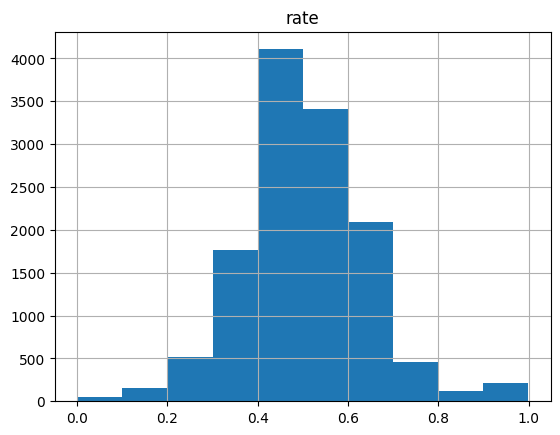

In [5]:
df['rate'] = normalize_rate(df)
df.hist('rate')

<Axes: xlabel='rate'>

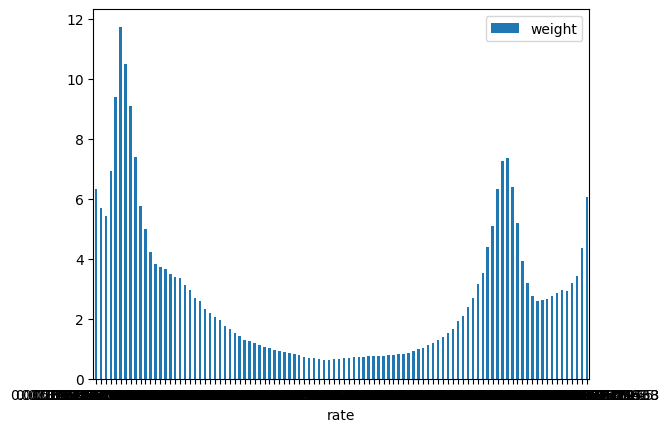

In [6]:
df['weight'] = get_weights(df['rate'], reweight=True)
df['ranges'] = pd.cut(df['rate'], bins=np.arange(0.0, 1.001, 0.01)).apply(lambda x: x.right)
df[['rate', 'weight', 'ranges']].groupby('ranges', as_index=False).mean().plot.bar(x='rate', y='weight', rot=0)

In [7]:
# import matplotlib.pyplot as plt
# from PIL import Image
# from io import BytesIO

# for i in range(30):
#     img = Image.open(BytesIO(df.loc[(df['rate'] > 0.6) & (df['rate'] < 0.7), 'img'].reset_index(drop=True).iloc[i]))
#     plt.figure()
#     plt.imshow(img)
#     plt.show()

In [8]:
df[['rate', 'img', 'weight']].to_parquet('../train.pqt')